# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [4]:
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

In [5]:
import sys
import gymnasium as gym

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [6]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [7]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

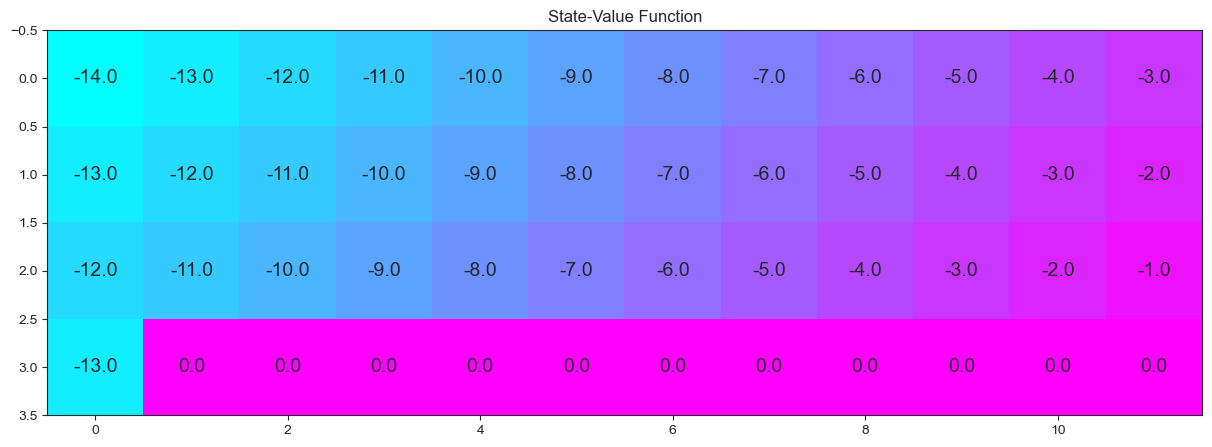

In [8]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [152]:
def sarsa(env, num_episodes, alpha, gamma=.95):
    nA = env.action_space.n
    
    # initialize empty dictionary of arrays (all lambda function is doing is defaulting unseen 
    # key's values to an array of 0s, in the length of the action space (in this case, 2 (hit, stay))
    Q = defaultdict(lambda: np.zeros(nA))
    
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        epsilon = 1/(i_episode)
            
        # monitor progress
        if i_episode % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        firstState = env.reset()[0]
        
        # find current greedy action (highest value)
        greedy_action = np.argmax(Q[firstState])

        # calculate probabilities following epsilon-greedy paradigm    
        probs = nA*[epsilon/nA]
        probs[greedy_action] += 1-epsilon

        # generate action based on those epsilon probabilities
        firstAction = np.random.choice(np.arange(nA), p=probs)
        secondState, firstReward, done, truncated, info = env.step(firstAction)
        
        epsilon = 1/(i_episode)
        
        while not done:
            
            # find current greedy action (highest value)
            greedy_action = np.argmax(Q[secondState])

            # calculate probabilities following epsilon-greedy paradigm    
            probs = nA*[epsilon/nA]
            probs[greedy_action] += 1-epsilon
            
            ## want to make sure the policy is updated based on the highest value in Q table

            # generate action based on those epsilon probabilities
            secondAction = np.random.choice(np.arange(nA), p=probs)
            thirdState, secondReward, done, truncated, info = env.step(secondAction)
            
            # update Q table
            Q[firstState][firstAction] = Q[firstState][firstAction] + alpha*((firstReward + gamma*(Q[secondState][secondAction])) - Q[firstState][firstAction])
            
            firstState = secondState
            firstAction = secondAction
            firstReward = secondReward
            secondState = thirdState
        
        # now update for last action
        Q[firstState][firstAction] = Q[firstState][firstAction] + alpha*(firstReward - Q[firstState][firstAction])
    
    return Q

                                             

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000.

**<span style="color: red;">PLEASE TRY AGAIN</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  2  2  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  2  1  2]
 [ 0  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


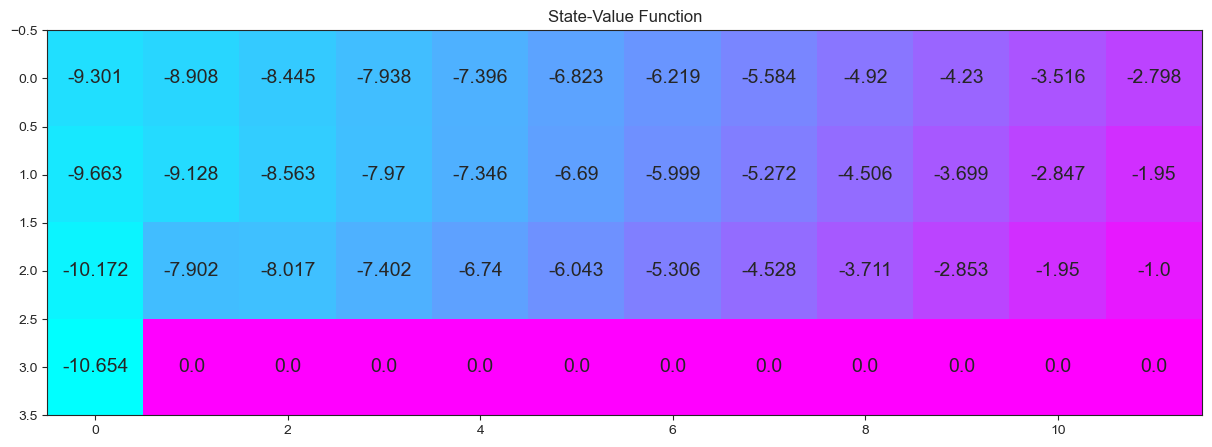

In [153]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

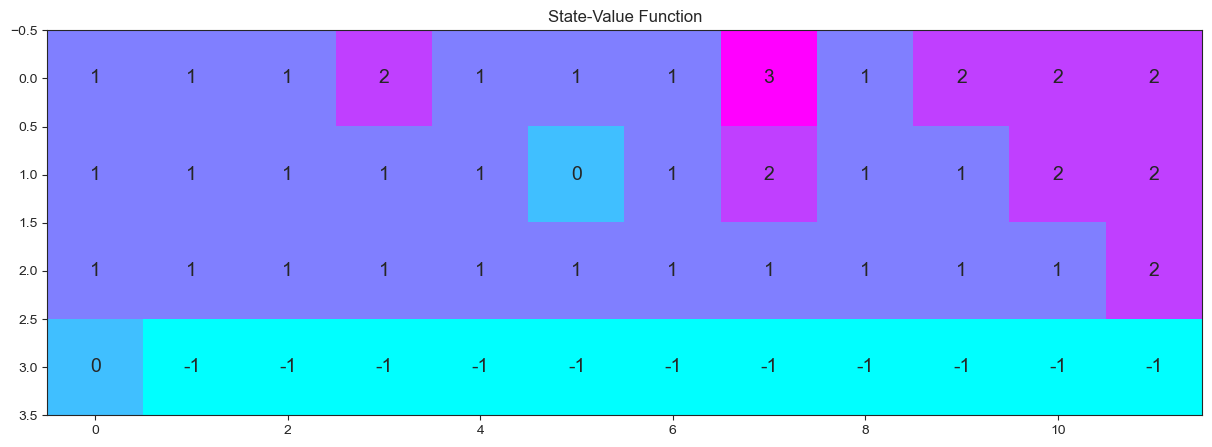

In [105]:
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
plot_values(policy_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [181]:
def q_learning(env, num_episodes, alpha, gamma=1):
    nA = env.action_space.n
    
    # initialize empty dictionary of arrays (all lambda function is doing is defaulting unseen 
    # key's values to an array of 0s, in the length of the action space (in this case, 2 (hit, stay))
    Q = defaultdict(lambda: np.zeros(nA))
    
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        epsilon = 1/(i_episode)
            
        # monitor progress
        if i_episode % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        firstState = env.reset()[0]
        
        # find current greedy action (highest value)
        greedy_action = np.argmax(Q[firstState])

        # calculate probabilities following epsilon-greedy paradigm    
        probs = nA*[epsilon/nA]
        probs[greedy_action] += 1-epsilon

        # generate action based on those epsilon probabilities
        firstAction = np.random.choice(np.arange(nA), p=probs)
        secondState, firstReward, done, truncated, info = env.step(firstAction)
        
        epsilon = 1/(i_episode)
        
        while not done:
            
            # find current greedy action (highest value)
            greedy_action = np.argmax(Q[secondState])

            # calculate probabilities following epsilon-greedy paradigm    
            probs = nA*[epsilon/nA]
            probs[greedy_action] += 1-epsilon
            
            ## want to make sure the policy is updated based on the highest value in Q table

            # generate action based on those epsilon probabilities
            secondAction = np.random.choice(np.arange(nA), p=probs)
            thirdState, secondReward, done, truncated, info = env.step(secondAction)
            
            # use greedy second action rather than policy's second action;
            # (this is the only change as opposed to normal sarsa - sarsamax simply choses
            # the max-likelihood action at any state rather than the action the policy chooses
            # via greedy-epsilon selection)
            
            # note: results seem to be almost identical between sarsa and sarsamax for this problem when
            # chosing epsilon to be 1/(episode number)
            
            # update Q table
            Q[firstState][firstAction] = Q[firstState][firstAction] + alpha*((firstReward + gamma*(Q[secondState][greedy_action])) - Q[firstState][firstAction])
            
            firstState = secondState
            firstAction = secondAction
            firstReward = secondReward
            secondState = thirdState
        
        # now update for last action
        Q[firstState][firstAction] = Q[firstState][firstAction] + alpha*(firstReward - Q[firstState][firstAction])
    
    return Q


Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000.

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  0  1  1  1  1  1  2  1  2]
 [ 1  1  0  1  2  3  2  1  2  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


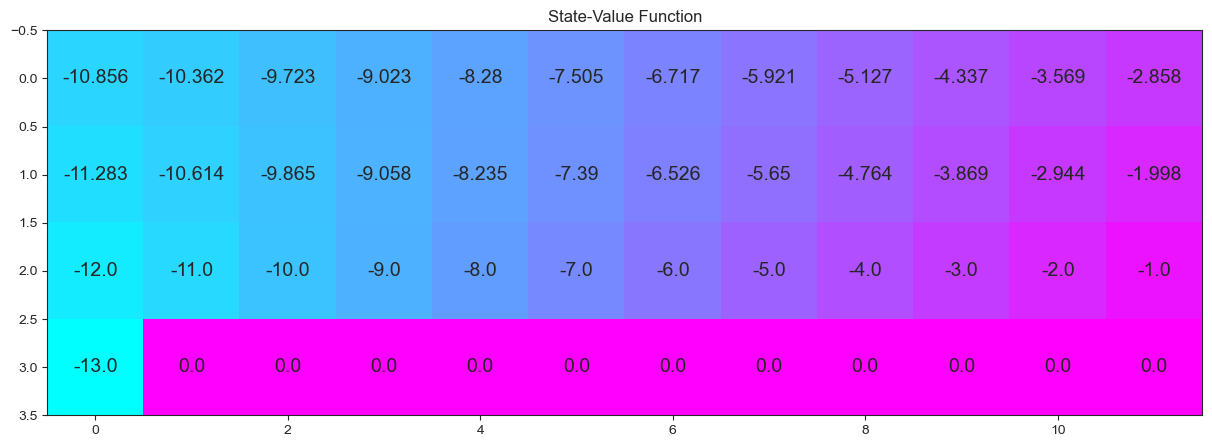

In [186]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .04)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [176]:
def expected_return(values, max_arg, epsilon, nA):
    average_value = sum(i*(epsilon/nA) for i in values)
    return average_value + (1-epsilon)*values[max_arg]

def expected_sarsa(env, num_episodes, alpha, gamma=1):
    nA = env.action_space.n
    
    # initialize empty dictionary of arrays (all lambda function is doing is defaulting unseen 
    # key's values to an array of 0s, in the length of the action space (in this case, 2 (hit, stay))
    Q = defaultdict(lambda: np.zeros(nA))
    
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        epsilon = 1/(i_episode)
            
        # monitor progress
        if i_episode % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        firstState = env.reset()[0]
        
        # find current greedy action (highest value)
        greedy_action = np.argmax(Q[firstState])

        # calculate probabilities following epsilon-greedy paradigm    
        probs = nA*[epsilon/nA]
        probs[greedy_action] += 1-epsilon

        # generate action based on those epsilon probabilities
        firstAction = np.random.choice(np.arange(nA), p=probs)
        secondState, firstReward, done, truncated, info = env.step(firstAction)
        
        epsilon = 1/(i_episode)
        
        while not done:
            
            # find current greedy action (highest value)
            greedy_action = np.argmax(Q[secondState])

            # calculate probabilities following epsilon-greedy paradigm    
            probs = nA*[epsilon/nA]
            probs[greedy_action] += 1-epsilon
            
            ## want to make sure the policy is updated based on the highest value in Q table

            # generate action based on those epsilon probabilities
            secondAction = np.random.choice(np.arange(nA), p=probs)
            thirdState, secondReward, done, truncated, info = env.step(secondAction)
            
            # use greedy second action rather than policy's second action;
            # (this is the only change as opposed to normal sarsa - sarsamax simply choses
            # the max-likelihood action at any state rather than the action the policy chooses
            # via greedy-epsilon selection)
            
            # note: results seem to be almost identical between sarsa and sarsamax for this problem when
            # chosing epsilon to be 1/(episode number)
            
            # update Q table
            Q[firstState][firstAction] = Q[firstState][firstAction] + alpha*((firstReward + gamma*expected_return(Q[secondState], greedy_action, epsilon, nA)) - Q[firstState][firstAction])
            
            firstState = secondState
            firstAction = secondAction
            firstReward = secondReward
            secondState = thirdState
        
        # now update for last action
        Q[firstState][firstAction] = Q[firstState][firstAction] + alpha*(firstReward - Q[firstState][firstAction])
    
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000.

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  1  1  2  1  3  1  1  2  1  2  2]
 [ 0  0  1  1  1  1  1  2  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


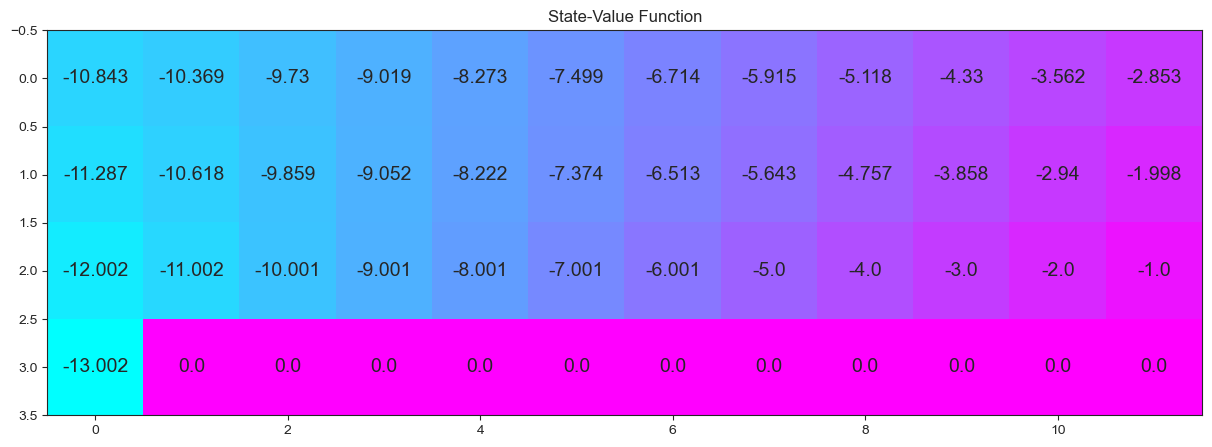

In [180]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, .014)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])